# Lecture 11: Introduction to Statistics and MLE method
## Delivered by Prof. Laerte Sodre Jr.

#### This notebook was developed by [Zeljko Ivezic](http://faculty.washington.edu/ivezic/) for the 2021 data science class at the University of Sao Paulo and it is available from [github](https://github.com/ivezic/SaoPaulo2021/blob/main/notebooks/Lecture11.ipynb).

Note: this notebook contains code developed by Z. Ivezic, M. Juric, A. Connolly, B. Sippocz, Jake VanderPlas, G. Richards and many others.

<a id='toc'></a>

## This notebook includes:

[Motivation and Goals](#goals)

[IPython (jupyter) notebooks](#notebooks)

[Basics about statistics](#basics) 

[Distributions and Random samples](#randoms)

[Robust statistics](#robust)

[Maximum likelihood method](#ML)

## Motivation and Goals for Lectures 11-20  <a id='goals'></a>
[Go to top](#toc)

### Motivation
    
These lectures will introduce students to most common statistical and computer science methods 
used in astronomy and other physical sciences. They will combine theoretical background with 
concrete examples of data analysis based on modern astronomical datasets. This practical data 
analysis will be done using python tools and jupyter notebooks. 

While most practical examples are focused on astronomy, this course should be useful to all 
students interested in data analysis in physical sciences and engineering. The lectures are 
aimed at graduate and upper level undergraduate students, and the main discussion topics are 
by and large based on Chapters 3-10, from the reference textbook
[Ivezić, Connolly, VanderPlas & Gray: Statistics, Data Mining, and Machine Learning in Astronomy:
A Practical Python Guide for the Analysis of Survey Data (Princeton University Press, 
2014)](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy)
 

By taking this course, students will develop working knowledge of topics such as robust 
statistics, hypothesis testing, maximum likelihood analysis, Bayesian statistics, model 
parameter estimation, the goodness of fit and model selection, density estimation and 
clustering, unsupervised and supervised classification, dimensionality reduction, regression 
and time series analysis.  
    
    
### Main Goals: 
1. Teach students pitfalls of working with real data, including robust statistics.  

2. Introduce the main data science concepts, such as Maximum Likelihood method, 
   Bayesian statisticsm supervised and unsupervised
   classification, dimensionality reduction, regression and time series analysis.

3. Using a specific quantitative data-based class project, explore to a deeper level
   above concepts, as well as additional methods such as regression and time 
   series analysis.  

## A quick introduction to ipython (jupyter) notebooks  <a id='notebooks'></a>
[Go to top](#toc)


### Introduction

In this notebook, we'll cover some basic statistics and we'll fit a line to a set of data points with Gaussian uncertainties in one dimension.   

This worksheet is written in Python and it lives in an IPython notebook. In this context, you'll be asked to write a few lines of code to implement the sampler and the models but much of the boilerplate code is already in place. Therefore, even if you're not familiar with Python, you should be able to get something out of the notebook. I don't expect that everyone will finish the full notebook but that's fine because it has been designed to get more difficult as we progress.

### How to use the notebook

*If you're familiar with IPython notebooks, you can probably skip this section without missing anything.*

IPython notebooks work by running a fully functional Python sever behind the scenes and if you're reading this then you probably already figured out how to get that running. Then, inside the notebook, the content is divided into cells containing code or text.

You'll be asked to edit a few of the cells below to add your own code. To do this, click on the cell to start editing and then type as you normally would. To execute the code contained in the cell, press `Shift-Enter`. Even for existing cells that you don't need to edit, you should select them and type `Shift-Enter` when you get there because the cells below generally depend on the previous cells being executed first.

To get started, edit the cell below to assign your name (or whatever you want) to the variable `name` and then press `Shift-Enter` to execute the cell.

In [1]:
import os
name = os.getlogin()
print("Hello {0}!".format(name))

Hello ivezic!


If this works, the output should greet you without throwing any errors. If so, that's pretty much all we need so let's get started!

## Basics about statistics <a id='basics'></a>
[Go to top](#toc)

##### Learning goals: 
- Probability Rules (notation, definitions, conditional probability, Bayes Rule).
- How do I robustly estimate location and scale parameters of a one-dimensional data set?  
- Statistical distributions and how do we describe them? 
- Estimators, location and scale, sample vs. population, bias and scatter.

### Notation and Variables

First we need to go over some of the notation that the book uses.   

$x$ is a scalar quantity, measured $N$ times

$x_i$ is a single measurement with $i=1,...,N$

$\{x_i\}$ refers to the set of all N measurements

### Parametric vs. Non-parametric

If we are attempting to guess a *model* for $h(x)$, then the process is *parametric*.  With a model solution we can generate new data that should mimic what we measure.

If we are not attempting to guess a model, then the process is *nonparametic*.  That is we are just trying to describe the data that we see in the most compact manner that we can, but we are not trying to produce mock data.

## Probability

The probability of $A$, $p(A)$, is the probability that some event will happen (say a coin toss), or if the process is continuous, the probability of $A$ falling in a certain range.  (N.B., Technically these two things are different and sometimes are indicated by $P$ and $p$, but we'll ignore that here).

$p(A)$ must be positive definite for all $A$ and the sum/integral of the pdf must be unity.

If we have two events, $A$ and $B$, the possible combinations are illustrated by the following figure:
![Figure 3.1](http://www.astroml.org/_images/fig_prob_sum_1.png)

$A \cup B$ is the *union* of sets $A$ and $B$.

$A \cap B$ is the *intersection* of sets $A$ and $B$.

The probability that *either* $A$ or $B$ will happen (which could include both) is the *union*, given by

$$p(A \cup B) = p(A) + p(B) - p(A \cap B)$$

The figure makes it clear why the last term is necessary.  Since $A$ and $B$ overlap, we are double-counting the region where *both* $A$ and $B$ happen, so we have to subtract this out.  


The probability that *both* $A$ and $B$ will happen, $p(A \cap B)$, is 

$$p(A \cap B) = p(A|B)p(B) = p(B|A)p(A)$$

where p(A|B) is the probability of A *given that* B is true and is called the *conditional probability*.  So the $|$ is short for "given that".

In other words: *"The probability that both A and B have occured is equal to the probability B has occured times the probability that A will occur if B occured".*

If events B_i are disjoint and their union is the set of all possible outcomes, then the **law of total probability** says that:

$$p(A) = \sum_ip(A|B_i)p(B_i)$$

Example:

    A = hit head on door frame, B = { is tall, is average, is short }
    P(A) = P(A|is tall) + P(B|is average) + P(C|is short)

N.B.  Just to be annoying, different people use different notation and the following all mean the same thing

$$p(A \cap B) = p(A,B) = p(AB) = p(A \,{\rm and}\, B)$$

We will use the comma notation as in the textbook.

It is important to realize that the following is *always* true
$$p(A,B) = p(A|B)p(B) = p(B|A)p(A)$$

However, if $A$ and $B$ are ***independent***, then 

$$p(A,B) = p(A)p(B)$$

Example:

     John is successful and John is a Libra.
     
In other words, ***knowing A happened tells us nothing about whether B happened (or will happen), and vice versa***.

Let's look at another example.

If you have a bag with 5 marbles, 3 yellow and 2 blue and you want to know the probability of picking 2 yellow marbles in a row, that would be

𝑝(𝑌1,𝑌2)=𝑝(𝑌1)𝑝(𝑌2|𝑌1).
 
𝑝(𝑌1)=35  since you have an equally likely chance of drawing any of the 5 marbles.

If you did not put the first marble back in the back after drawing it (sampling without "replacement"), then the probability  𝑝(𝑌2|𝑌1)=24 , so that
𝑝(𝑌1,𝑌2)=3524=310.
 
But if you put the first marble back, then  𝑝(𝑌2|𝑌1)=35=𝑝(𝑌2) , so that
𝑝(𝑌1,𝑌2)=3535=925.
 
In the first case  𝐴  and  𝐵  (or rather  𝑌1  and  𝑌2 ) are not independent, whereas in the second case they are.

Here is a more complicated example from 
[Jo Bovy's class at UToronto](http://astro.utoronto.ca/%7Ebovy/teaching.html)
![Bovy_L1-StatMiniCourse_page21](figures/Bovy_L1-StatMiniCourse_page21.png)

As illustrated, 
$$p(A \,{\rm or}\, B|C) = p(A|C) + p(B|C) - p(A \, {\rm and}\, B|C)$$ 

This illustration also explains why $$p(x|y)p(y) = p(y|x)p(x)$$ (used below),
or in the notation of this figure: $$p(A \, {\rm and}\, B) \equiv p(A,B) = p(A|B)p(B) = p(B|A)p(A)$$



Need more help with this? Try watching some Khan Academy videos and working through the exercises: https://www.khanacademy.org/math/probability/probability-geometry

https://www.khanacademy.org/math/precalculus/prob-comb

## Bayes' Rule

We've seen that the probability of $x$ and $y$ occurring can be written as:

$$p(x,y) = p(x|y)p(y) = p(y|x)p(x)$$

We can define the ***marginal probability*** as

$$p(x) = \int p(x,y)dy,$$

where marginal means the probability of $x$ occurring irrespective what $y$ is. This is essentially projecting on to one axis (integrating over the other axis, see the figure in the Notebook, below).

Given these two, we can write:

$$p(x) = \int p(x|y)p(y) dy$$

This is just the law of total probability, but for continous variables.

**Note:** this is related to a much broader and deeper concept of Bayesian Statistics,
which we will introduce in Lecture 12.

## Marginal and contitional probability distributions

In the following figure, we have a 2-D distribution in $x-y$ parameter space.  Here $x$ and $y$ are *not* independent as, once you pick a $y$, your values of $x$ are constrained.

The *marginal* distributions are shown on the left and bottom sides of the left panel.  As the equation above says, this is just the integral along the $x$ direction for a given $y$ (left side panel) or the integral along the $y$ direction for a given $x$ (bottom panel).  

The three panels on the right show the *conditional* probability (of $x$) for three $y$ values: $$p(x|y=y_0)$$  These are just "slices" through the 2-D distribution.

![http://www.astroml.org/_images/fig_conditional_probability_1.png](http://www.astroml.org/_images/fig_conditional_probability_1.png)

Then, again starting with:

$$p(x|y)p(y) = p(y|x)p(x)$$

we can write:

$$p(y|x) = \frac{p(x|y)p(y)}{p(x)} = \frac{p(x|y)p(y)}{\int p(x|y)p(y) dy}$$

which in words says that

> the (conditional) probability of $y$ given $x$ is just the (conditional) probability of $x$ given $y$ times the (marginal) probability of $y$ divided by the (marginal) probability of $x$, where the latter is just the integral of the numerator.

This is **Bayes' rule**, which itself is not at all controversial, though its application can be as we'll discuss later (first in Lecture 12). 

## Distributions and Random samples <a id='randoms'></a>
[Go to top](#toc)

##### Learning goals: 
- How do I use python to generate various statistical distributions, such as Cauchy, Laplace, etc.? 

## Statistical distributions

Typically, we collect some *samples* (series of measurements, or catalogs of stars) that can be thought of as being drawn from som underlying distribution (e.g., distribution of errors, or the distribution of stars in the Milky Way).

We often don't care much about the individual samples, other than to use them ***to learn more about the underlying distributions and their properties (e.g., the mean (location), width (scale), etc.)***. How do we do that?

![SlideGrab](figures/p5.jpg)

Normal probability density function (pdf): $$p(x|\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right).$$

Cumulative distribution function (cdf): $$\Phi(x|\mu,\sigma) = \int_{-\infty}^{x}  p(x'|\mu,\sigma) dx' $$
$$\Phi(\infty|\mu,\sigma) = 1.$$

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

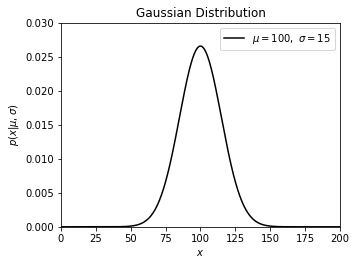

In [3]:
## Let's play with Gaussians! Or Normal distributions, N(mu,sigma)
## see http://www.astroml.org/book_figures/chapter3/fig_gaussian_distribution.html
## Example: IQ is (by definition) distributed as N(mu=100,sigma=15)
## Let's plot the IQ distribution first
# generate distribution for a grid of x values
x = np.linspace(0, 200, 1000)
mu=100
sigma=15
gauss = norm(mu, sigma).pdf(x)  # this is a function of x: gauss(x)
# actual plotting
fig, ax = plt.subplots(figsize=(5, 3.75))
plt.plot(x, gauss, ls='-', c='black', label=r'$\mu=%i,\ \sigma=%i$' % (mu, sigma))
plt.xlim(0, 200)
plt.ylim(0, 0.03)
plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\sigma)$')
plt.title('Gaussian Distribution')
plt.legend()
plt.show()

In [4]:
## above we used probability density function (astronomers like to call it "differential" df)
## the cumulative distribution function, cdf, is the integral of pdf from $x'=-\infty$ to $x'=x$
# What fraction of people have IQ>145 (in other words, what fraction of people are "3-sigma" above the average?
gaussCDF = norm(mu, sigma).cdf(145)
print (1-gaussCDF)

0.0013498980316301035


In [5]:
# What IQ corresponds to a "one in a million people genius"? 
nSigma = norm.ppf(1-1.0e-6)
# norm.ppf returns x for specified cdf, assuming mu=0 and sigma=1 ("standard normal pdf")
IQ = mu + nSigma*sigma
print('nSigma=',nSigma)
print('IQ=', IQ)

nSigma= 4.753424308817087
IQ= 171.3013646322563


In [6]:
# let's now look at the same problems using a sample of million points drawn from N(100,15)
sampleSize=1000000 
gaussSample = norm(mu, sigma).rvs(sampleSize) 
# What fraction of people have IQ>145?
smartOnes = gaussSample[gaussSample>145]
print (1.0*np.size(smartOnes)/sampleSize)

0.001321


In [7]:
# What IQ corresponds to "one in a million"?  
print(np.max(gaussSample))

178.08565584727302


## Why do the two sets of results differ (0.00135 vs. 0.00138 and 171.3 vs. 176.8)?

In [8]:
def printStats(v):
    print('Size:', np.size(v))
    print('min:', np.min(v))
    print('max:', np.max(v))
    print('mean:', np.mean(v))
    print('median:', np.median(v))
    print('st.dev.:', np.std(v))

In [9]:
printStats(gaussSample)

Size: 1000000
min: 29.96191477070849
max: 178.08565584727302
mean: 99.98313486277632
median: 99.97043289295704
st.dev.: 15.008769410658832


In [10]:
printStats(smartOnes)

Size: 1321
min: 145.0036294837878
max: 178.08565584727302
mean: 149.30360116805895
median: 148.21402961061517
st.dev.: 4.019416901588777


In [11]:
# What about the other end of the spectrum?
print('N(50 < IQ < 71):    ', np.size(gaussSample[(gaussSample>50) & (gaussSample<71)]))
print('N(26 < IQ < 51):    ', np.size(gaussSample[(gaussSample>26) & (gaussSample<51)]))

N(50 < IQ < 71):     26198
N(26 < IQ < 51):     542


### Gaussian confidence levels

The probability of a measurement drawn from a Gaussian distribution that is between $\mu-a$ and $\mu+b$ is
$$\int_{\mu-a}^{\mu+b} p(x|\mu,\sigma) dx.$$
For $a=b=1\sigma$, we get the familar result of 68.3%.  For $a=b=2\sigma$ it is 95.4%.  So we refer to the range $\mu \pm 1\sigma$ and $\mu \pm 2\sigma$ as the 68% and 95% **confidence limits**, respectively.

In [12]:
## now let's go back to the problem of estimating location and scale
## given a sample, such as gaussSample above, how do we estimate its mu and sigma?

![SlideGrab](figures/p4.jpg)

![SlideGrab](figures/p3.jpg)

### Sample vs. Population Statistics 

Statistics estimated from the *data* are called _sample statistics_ as compared to _population statistics_ which come from knowing the functional form of the pdf. For example, the expectation value for a known h(x) is

$$\mu \equiv E(x) = \int_{-\infty}^{\infty} x h(x) dx,$$

where $h(x)$ must be properly normalized (the integral gets replaced by a sum for discrete distributions).

E(x) is the expecation value of $x$.  If you want the expectation value of something else--say $x^2$ or $(x-\mu)^2$, you replace $x$ with that. Importantly, the *variance* is the expectation value of $(x-\mu)^2$

$$\sigma^2 \equiv V = \int_{-\infty}^{\infty}  (x-\mu)^2 h(x) dx,$$

where, again, the integral gets replaced by a sum for discrete distributions.

Specifically, $\mu$ is the *population average*, i.e., it is the expecation value of $x$ for $h(x)$.  But we don't *know* $h(x)$! So we do the next best thing, and estimate it from the data:

$$ \hat{h}(x) = \sum_{i=1}^N \frac{\delta_(x - x_i)}{N}$$

Plugging into the previous equations, we derive the **sample mean**, $\overline{x}$ as an *estimator* of $\mu$ and defined as
$$\overline{x} \equiv \frac{1}{N}\sum_{i=1}^N x_i,$$
which we determine from the data itself. We'll hear more about estimators in Week 4.

Similarly, the **sample variance** ($s^2$, where 
$s$ is the sample standard deviation) is an *estimator* of $\sigma^2$:
$$s^2 \equiv \frac{1}{N-1}\sum_{i=1}^N (x_i-\overline{x})^2.$$

**WAIT!!!** Why do we have (N-1) and not N (as in expression for the mean)???

The reason for the (N-1) term instead of the naively expected N in the second expression is related to the fact that $\overline{x}$ is also determined from data (we will discuss this subtle fact and the underlying statistical justification for the (N-1) term in more detail in Week 4 lectures. With N replaced by (N-1) (the so-called Bessel’s correction), the sample variance (i.e., $\sigma^2$) becomes unbiased (and the sample standard deviation becomes a less biased, but on average still underestimated, estimator of the true standard deviation). 

What does "biased" mean? 

![SlideGrab](figures/p13.jpg)

![SlideGrab](figures/p10.jpg)

![SlideGrab](figures/p11.jpg)

![SlideGrab](figures/p12.jpg)

![SlideGrab](figures/p8.jpg)

## WARNING: do not overinterpret simple statistics!

Anscombe's quartet comprises four datasets that have nearly identical simple descriptive statistics, yet appear very different when graphed. 

![SlideGrab](figures/AnscombeQuartet.jpg)

![SlideGrab](figures/AnscombeQuartetTable.jpg)



## Robust statistics <a id='robust'></a>
[Go to top](#toc)

##### Learning goals: 
- How do I *robustly* estimate location and scale parameters of a one-dimensional data set?  

**Robust** here means insensitive to outliers; for example, a single data point 
in a sample with a value going to infinity will result in the sample mean also
going to infinity -- therefore, the sample mean is **not** a robust estimator.

However, the sample median **is** a robust estimator: not only a single data point,
but essentially 50% of all points can have values going to infinity and the sample median
will remain unchanged! 

Similarly, to estimate the distribution width, instead of using standard deviation we
can use the interquartile range. 

We will discuss robust statistics in more detail, and with numerical examples, later today. 

## Maximum Likelihood Estimation (MLE) Method<a id='ML'></a>
[Go to top](#toc)

### Topics for today: 

a) introduction: what likelihood is and what it is good for

b) simple examples of MLE: one-dimensional gaussian

c) MLE in action: fitting a parametrized model with heteroscedastic gaussian errors on y axis

d) cost functions and penalized likelihood 

e) non-gaussian likelihood: binomial distribution (coin flip problem)

f) conceptual difficulties with the MLE (example: "waiting for a bus" problem)

g) what if we cannot write down the likelihood function? 

### a) introduction: what likelihood is and what it is good for

#### Example: 
If I draw values from a Gaussian $N(\mu, \sigma)$, e.g. measuring quantity $\mu$
with uncertainty $\sigma$ (somewhat erroneously a.k.a. “error bar”), 

then the probability that the measured value will be between $x$ and $x+dx$ is 

$$ p(x) = N(\mu,\sigma) * dx $$
where
      $$ N(\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right).$$


For a sample of $N$ data points, $\{x_i\}$, where the uncertainty for each measurement is Gaussian with
a known $\sigma$, the likelihood of all N measurements is

$$L \equiv p(\{x_i\}|\mu,\sigma) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right).$$

**An important assumption** that we made here is that random noise for different 
data points is independent (if it's not, we need to use methods such as Gaussian
process modeling). This assumption allowed us to simply multiply the likelihoods
for individual data points to obtain the likelihood of the whole dataset. 


Let's now see some numerical illustrations...
 

In [13]:
from __future__ import print_function, division, absolute_import
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
np.random.seed(42)
%matplotlib inline  

In [14]:
### Let's draw a homoscedastic sample of {x_i} from a Gaussian and see what happens with L
# first generate a sample of N points drawn from N(mu,sigma):
sampleSize=3
mu = 1.0
sigma = 0.2 
sample = norm(mu, sigma).rvs(sampleSize) 
print('our data points:', sample)

our data points: [1.09934283 0.97234714 1.12953771]


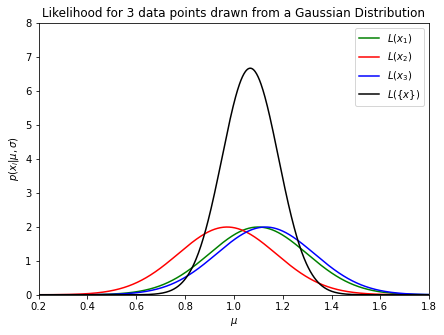

In [15]:
### Let's draw a homoscedastic sample of {x_i} from a Gaussian and see 
### what happens with L 
# now compute likelihoods for each point using true mu 
muGrid = np.linspace(0,2,1000)
L1 = norm(sample[0], sigma).pdf(muGrid) 
L2 = norm(sample[1], sigma).pdf(muGrid) 
L3 = norm(sample[2], sigma).pdf(muGrid) 
L = L1 * L2 * L3
# plot
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(muGrid, L1, ls='-', c='green', label=r'$L(x_1)$')
plt.plot(muGrid, L2, ls='-', c='red', label=r'$L(x_2)$')
plt.plot(muGrid, L3, ls='-', c='blue', label=r'$L(x_3)$')
plt.plot(muGrid, L, ls='-', c='black', label=r'$L(\{x\})$')

plt.xlim(0.2, 1.8)
plt.ylim(0, 8.0)
plt.xlabel('$\mu$')
plt.ylabel(r'$p(x_i|\mu,\sigma)$')
plt.title('Likelihood for 3 data points drawn from a Gaussian Distribution')
plt.legend()
plt.show() 

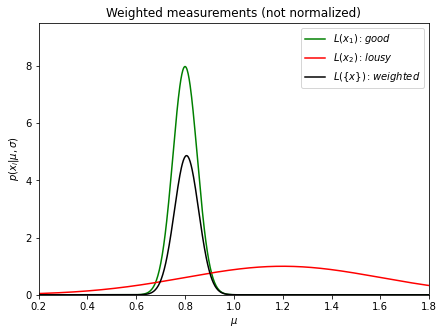

In [16]:
### What happens when we have one precise and one lousy measurement? 
L1 = norm(0.8, 0.05).pdf(muGrid)    
L2 = norm(1.2, 0.40).pdf(muGrid)     ## this is the lousy one: sigma = 0.4 >> 0.05
L = L1 * L2 
# plot
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(muGrid, L1, ls='-', c='green', label=r'$L(x_1): good$')
plt.plot(muGrid, L2, ls='-', c='red', label=r'$L(x_2): lousy$')
plt.plot(muGrid, L, ls='-', c='black', label=r'$L(\{x\}): weighted$')

plt.xlim(0.2, 1.8)
plt.ylim(0, 9.5)
plt.xlabel('$\mu$')
plt.ylabel(r'$p(x_i|\mu,\sigma)$')
plt.title('Weighted measurements (not normalized)')
plt.legend()
plt.show() 
 

**If either of the two likelihoods (or one of the likelihood and prior pair) is 
the Dirac's $\delta$ function ("zero width"), the posterior is the same delta function.**
 

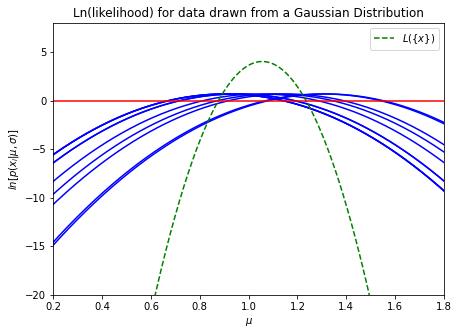

In [17]:
### Same as above, but with 10 points and on log scale
sampleSize=10
sampleBig = norm(mu, sigma).rvs(sampleSize) 
lnL = 0*muGrid
# compute and plot
fig, ax = plt.subplots(figsize=(7, 5))
for i in range(0,sampleSize):
    lnLone = np.log(norm(sampleBig[i], sigma).pdf(muGrid)) 
    plt.plot(muGrid, lnLone, ls='-', c='blue')
    lnL += lnLone 
plt.plot(muGrid, lnL, ls='--', c='green', label=r'$L(\{x\})$')

plt.axhline(y=0.0, color='red', linestyle='-')
plt.xlim(0.2, 1.8)
plt.ylim(-20.0, 8.0)
plt.xlabel('$\mu$')
plt.ylabel(r'$ln[p(x_i|\mu,\sigma)]$')
plt.title('Ln(likelihood) for data drawn from a Gaussian Distribution')
plt.legend()
plt.show() 

#### Important Notes: 
- likelihood values can be very small - the use of ln() (natural logarithm; giving log-likelihood) helps with displaying large dynamic range
- the use of ln()  is even more important when likelihoods for individual data points are multiplied: the product of likelihoods becomes a sum of ln(likelihood)
- the sample likelihood is not a true probability distribution - its integral is not 1! 
- the more data we add, the more "peaked" is the likelihood $L(\{x\})$ around
  the true value of $\mu$ (=1.0); this is the famous $1/\sqrt{N}$ behavior and we'll return to this point



#### Example: 
If I draw values from a Gaussian $N(\mu, \sigma)$, e.g. measuring quantity mu
with uncertainty $\sigma$ (somewhat erroneously a.k.a. “error bar”), 

then the probability that the measured value will be between $x$ and $x+dx$ is 

$$ p(x) = N(\mu,\sigma) * dx $$
where
      $$ N(\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right).$$



#### What's so special about Gaussian (normal) distribution? 
- a Gaussian comes from the Central Limit Theorem (the mean of samples drawn from an almost 
    arbitrary distribution will follow a Gaussian distribution) 
- Gaussians have nice properties (convolution, Fourier transform, independence of mean and variance)
- Poisson distribution morphs into a Gaussian distribution for large $\mu$

** but likelihood function doesn’t have to be a gaussian!!! ** (it could be, e.g., exponential, 
uniform, poisson, or double gaussian distribution)

  

### a) introduction: what likelihood is and what it is good for

In everyday life, "likelihood" is often used as a synonym for "probability.” 

In statistics, **probability is used before data are available** to describe possible future 
outcomes given fixed model parameters (“a function of x with theta fixed”, like above), 
while **likelihood is used after data are available** to describe a function of model parameters 
for a given outcome (“a function of theta with x fixed”). ** But it's the same function (as above)!**

The two main reasons we are talking about the likelihood function

- Maximum Likelihood Estimation (MLE) is one of the most important methods in statistics
- The likelihood function is a crucial ingredient in the Bayesian framework (note for later: in case of flat priors, MLE produces numerically identical result as the Bayesian Maximum A Posteriori, MAP, estimate)

### Maximum Likelihood Estimation (MLE) is one of the most important methods in statistics 

**MLE:** Assume that the likelihood function is given by
$$L(\mu,\sigma) \equiv p(\{x_i\}|\mu,\sigma) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right).$$

An astronomical example of the above would be velocity measurements for the Milky
Way halo stars ($\mu \sim 0$ km/s, $\sigma \sim 100$ km/s), with measurement
uncertainties negligible compared to $\sigma$ (say, $\sim1$ km/s).

We can make use of   
$$\prod_{i=1}^n A_i \exp(-B_i) = (A_iA_{i+1}\ldots A_n) \exp[-(B_i+B_{i+1}+\ldots+B_n)]$$
and obtain
$$lnL(\mu,\sigma) \equiv ln[p(\{x_i\}|\mu,\sigma)] = const. - \frac{1}{2}\sum_{i=1}^N \frac{(x_i-\mu)^2}{\sigma^2}.$$

** An important side note** 
In case of gaussian likelihood, maximizing $lnL$ is equivalent to 
minimizing "chi-square"
$$\chi2 = \sum_{i=1}^N \frac{(x_i-\mu)^2}{\sigma^2}.$$ 
In other words,
$$ L \propto exp(-\frac{\chi^2}{2}).$$

** MLE estimates** 

The best estimates of $\mu$ and $\sigma$ are those that maximize $L(\mu,\sigma)$, or $lnL(\mu,\sigma)$,
for a given dataset $\{x_i\}$ ($i=1..N$).

E.g. the MLE for $\mu$, usually called $\hat \mu$ (and sometimes 
$\mu_0$), is obtained from 
$$\frac{d\;{lnL}(\mu)}{d\mu}\Biggr\rvert_{\hat \mu} \equiv 0,$$


** Uncertainties of MLE estimates** 

The uncertainty of this estimate is fully captured by the likelihood function, 
but we'd like to quantify it with a few numbers. We *define* the uncertainty 
on our MLEs using second (partial) derivatives of log-likelihood:

$$\sigma_{jk} = \left([F^{-1}]_{jk}\right)^{1/2},$$
where $\theta$ is a vector of model parameters.

$[F^{-1}]_{jk}$ is an element of the inverse of the covariance matrix $F$, defined as  
$$F_{jk} = -\frac{d^2}{d\theta_j} \frac{\ln L}{d\theta_k} \Biggr\rvert_{\theta=\hat \theta}.$$

The marginal uncertainty for each model parameter, $\theta_i$, are given by the diagonal 
elements, $\sigma_{ii}$. These are the "error bars" that are typically quoted with each measurement.

In the one-dimensional case discussed above, we have
$$\sigma_{\mu} = \left( - \frac{d^2 ln L}{d\mu^2}  \Biggr\rvert_{\mu=\hat \mu}\right)^{-1/2},$$




### b) simple examples of MLE: one-dimensional gaussian

#### Maximum Likelihood Estimation (MLE) applied to a Heteroscedastic Gaussian

For example, assume $N$ measurements, $\{x_i\}$, where the uncertainty for each measurement is Gaussian with
a known $\sigma_i$. The likelihood of one measurement is 

$$p(x_i|\mu,\sigma_i) = \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma_i^2}\right).$$


and therefore the likelihood of all N measurements is

$$L \equiv p(\{x_i\}|\mu,\sigma_i) = \prod_{i=1}^N \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma_i^2}\right).$$

An astronomical example of the above would be measurements of the mass
of an object, $\mu$ (that is, there is no intrinsic $\sigma$, only measurement
errors $\sigma_i$).

The more convenient log-likelihood is 
$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

Taking the derivative:
$$\frac{d\;{\rm lnL}(\mu)}{d\mu}\Biggr\rvert_{\mu_0} = \sum_{i=1}^N \frac{(x_i - \mu_o)}{\sigma_i^2} = 0,$$
then simplifying:

$$\sum_{i=1}^N \frac{x_i}{\sigma_i^2} = \sum_{i=1}^N \frac{\mu_o}{\sigma_i^2},$$

yields a MLE solution of 
$$\mu_0 = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

with uncertainty (from the second derivative)
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$

 
In case of homoscedastic uncertainties, we get the familiar expression
$$\sigma_{\mu} = \frac{\sigma}{\sqrt{N}}.$$


** Know your likelihood! **

The result for $\sigma_{\mu}$ has been derived by expanding $\ln L$ in a Taylor 
series and retaining terms up to second order (essentially, the surface of $\ln L$ 
is approximated by a parabola, or an ellipsoidal surface in multidimensional cases, 
around its maximum). If this expansion is exact (as is the case for a Gaussian error 
distribution), then we've completely captured the error information (see illustration
below). 

In general, this is not the case and the likelihood surface can significantly deviate 
from a smooth elliptical surface. Furthermore, it often happens in practice that the 
likelihood surface is multimodal. It is always a good idea to visualize the likelihood 
surface when in doubt.
 

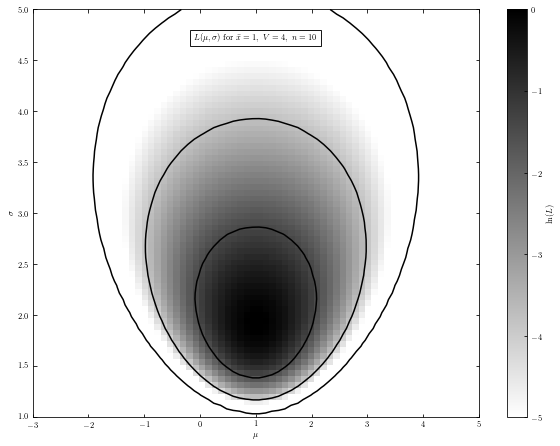

In [18]:
"""
Log-likelihood for Gaussian Distribution
----------------------------------------
Figure5.4
An illustration of the logarithm of the posterior probability density
function for :math:`\mu` and :math:`\sigma`, :math:`L_p(\mu,\sigma)`
(see eq. 5.58) for data drawn from a Gaussian distribution and N = 10, x = 1,
and V = 4. The maximum of :math:`L_p` is renormalized to 0, and color coded as
shown in the legend. The maximum value of :math:`L_p` is at :math:`\mu_0 = 1.0`
and :math:`\sigma_0 = 1.8`. The contours enclose the regions that contain
0.683, 0.955, and 0.997 of the cumulative (integrated) posterior probability.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


def gauss_logL(xbar, V, n, sigma, mu):
    """Equation 5.57: gaussian likelihood"""
    return (-(n + 1) * np.log(sigma)
            - 0.5 * n * ((xbar - mu) ** 2 + V) / sigma ** 2)

#------------------------------------------------------------
# Define the grid and compute logL
sigma = np.linspace(1, 5, 70)
mu = np.linspace(-3, 5, 70)
xbar = 1
V = 4
n = 10

logL = gauss_logL(xbar, V, n, sigma[:, np.newaxis], mu)
logL -= logL.max()

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 7.5))
plt.imshow(logL, origin='lower',
           extent=(mu[0], mu[-1], sigma[0], sigma[-1]),
           cmap=plt.cm.binary,
           aspect='auto')
plt.colorbar().set_label(r'$\ln(L)$')
plt.clim(-5, 0)

plt.contour(mu, sigma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='k')

plt.text(0.5, 0.93, r'$L(\mu,\sigma)\ \mathrm{for}\ \bar{x}=1,\ V=4,\ n=10$',
         bbox=dict(ec='k', fc='w', alpha=0.9),
         ha='center', va='center', transform=plt.gca().transAxes)

plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

plt.show()



In [19]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import norm
from astroML.plotting import hist
np.random.seed(42)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

### Confidence Interval vs. Credible Region

In case of homoscedastic gaussian uncertainties, our estimator of $\mu$ is 
$\overline{x}\pm\frac{\sigma}{\sqrt{N}}$, which is a result that you are most likely familiar with.

In the **frequentist paradigm**, the meaning of the *confidence interval* $\mu_0 \pm \sigma_{\mu}$ is 
the interval that would contain the true $\mu$ (from which the data were drawn) in 68% cases
of a large number of imaginary repeated experiments (each with a different N values of $\{x_i\}$). 
If we repeated the same measurement a hundred times, we'd find for 68 experiments the true value 
was within their computed confidence intervals ($1 \sigma$ errors).
 

Numerically, the same interval follows from the **Bayesian approach** with uniform priors.
However, the meaning of that so-called *credible region* is *fundamentally different*: it is the interval
that contains the true $\mu$ with a probability of 68%, given the given dataset (our dear one and only 
dataset - there are no imaginary experiments in Bayesian paradigm). This credible region is the 
relevant quantity in the context of scientific measurements. 

For more details, read
- [E.T. Jaynes: ``Confidence Intervals vs. Bayesian intervals''](http://bayes.wustl.edu/etj/articles/confidence.pdf)

- [Jake's excellent blog](http://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/)
  

### The Essence of the Bayesian Method 

The basic premise of the Bayesian method is that probability statements are not limited to data, 
but can be made for model parameters and models themselves. Inferences are made by producing 
probability density functions (pdfs); most notably, **model parameters are treated as random variables**.



### Properties of ML Estimators

Assuming the data truly are drawn from the model, ML estimators have the following useful properties:

* **They are consistent estimators**; that is, they can be proven to converge to the true parameter value as the number of data points increases.
* **They are asymptotically normal estimators**. The distribution of the parameter estimate, as the number of data points increases to infinity, approaches a normal distribution, centered at the MLE, with a certain spread. This spread can often be easily calculated and used as a confidence band around the estimate.
* **They asymptotically achieve the theoretical minimum possible variance for an unbiased estimator, called the Cramér–Rao bound**. In other words, they achieve the best possible error given the data at hand; that is, no other estimator can do better in terms of efficiently using each data point to reduce the total error of the estimate.

### Summary of the Maximum Likelihood Approach

Maximum likelihood estimation consists of the following conceptual steps:

1. **Hypothesis**: Formulate a model, a *hypothesis*, about how the data are generated. For example, this could be a statement that the data are a measurement of some quantity that come with Gaussian random errors (i.e., each measurement is equal to the true value, plus a deviation randomly drawn from the normal distribution). Models are typically described using a set of model parameters $\boldsymbol{\theta}$, and written as $\boldsymbol{M}(\boldsymbol{\theta})$.
2. **Maximum Likelihood Estimation**: Search for the "best" model parameters $\boldsymbol{\theta}$ which maximize the ***likelihood*** $L(\boldsymbol{\theta}) \equiv p(D|M)$. This search yields the MLE *point estimates*, $\boldsymbol{\theta_0}$ (or $\hat\theta$).
3. **Quantifying Estimate Uncertainty**: Determine the confidence region for model parameters, $\boldsymbol{\theta_0}$. Such a confidence estimate can be obtained analytically (possibly with some approximations), but can also be done numerically for arbitrary models using general frequentist techniques, such as bootstrap, jackknife, and cross-validation.
4. **Hypothesis Testing**: Perform hypothesis tests as needed to make other conclusions about models and point estimates. Possibly GOTO #1.

While these steps represent a blueprint for the frequentist approach in general, the likelihood is just one of many possible so-called objective functions (also called fitness functions, or cost functions). 


### c) MLE in action: fitting a parametrized model with heteroscedastic gaussian errors on y axis


Let us assume that we have $N$ pairs of measurements, $\{x_i, y_i\}$, where uncertainties for 
$\{x_i\}$ are negligible and uncertainty for each measurement $y_i$ is Gaussian and described
by a known $\sigma_i$. We also postulate that $\{y_i\}$ can be modeled as 
$$ y_i = f(x_i,\theta) + N(0,\sigma_i),$$
where $f(x,\theta)$ is some function of $x$ and a vector of model parameters $\theta$. 

For example, for the straight line fit, we have $f(x_i,\theta) = \theta_0 + \theta_1 x_i$. 

Because the noise is gaussian, the data likelihood can be written as 
$$L \equiv p(\{x_i, y_i\}|\theta,\sigma_i) = \prod_{i=1}^N \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(y_i-f(x_i,\theta))^2}{2\sigma_i^2}\right).$$

The more convenient log-likelihood is 
$$\ln L = {\rm constant} - \frac{1}{2}\sum_{i=1}^N \frac{[y_i - f(x_i,\theta)]^2}{\sigma_i^2}.$$

and we can estimate model parameters from
$$\frac{d\;{\rm lnL}(\theta_k)}{d\theta_k}\Biggr\rvert_{\hat \theta_k} \equiv 0, $$  
and their uncertainties from the inverse of the covariance matrix, as was discussed above.
 
In case of straight line fit, we can even derive a closed-form solution for the line slope
and intercept - this is the famous **Least Squares Method**. Now you know why the *squares*
of the residuals are minimized: because the square comes from the argument in the exponential
term of the *gaussian* error distribution!  But it doesn't have to be gaussian - and this
LSQ is not a universal method! For a different error distribution, you get a different 
result (e.g. exponential distribution, double-gaussian distribution). 

### An excellent astronomical example: the PSF (point-spread-function) flux 

We adopt a model $f(x_i, A) = A*psf(x_i)$, where we assumed 
- vector x_i corresponds to two-dimensional position in an image
- vector y_i corresponds to measured counts at position x_i
- the psf profile, $psf(x)$, is known, including centering 
 
Assuming homoscedastic errors, $\sigma$ (case of faint sources, where the noise is dominated
by the background, and not by the source), it is easy to show (try it!) by maximizing 
likelihood as a function of the single model parameter $A$ that the ML estimate for A is 
$$  \hat A = \sum_i \frac{y_i * psf(x_i)}{psf(x_i)^2}, $$
where it PSF normalization is assumed ($\sum_i psf(x_i) = 1$).  And by using the second
derivative, you can show that the uncertainty of this estimate is 

$$ \sigma_A = \left( \frac{\sigma^2}{\sum_i psf(x_i)^2} \right)^{1/2}.$$


For more details, see Section 4.3 (page 10) in 
[LSST Document LSE‐40 (The LSST Photon Rates and SNR Calculations, v1.2)](http://faculty.washington.edu/ivezic/Teaching/Astr511/LSST_SNRdoc.pdf)

###  d) cost functions and penalized likelihood 

We obtained model parameters by maximizing log-likelihood
$$\ln L = {\rm constant} - \frac{1}{2}\sum_{i=1}^N \frac{[y_i - f(x_i,\theta)]^2}{\sigma_i^2}.$$

This likelihood is just one of many possible so-called objective functions, or cost functions. 
Here the cost function quantifies some “cost” associated with parameter estimation. 

The expectation value of the cost function is called “risk” and can be minimized to obtain 
best-fit parameters. An often used form of risk is the mean integrated square error (MISE)
defined as,
$$ MISE = \int_{-\infty}^{\infty} [y(x) − f(x)]^2 dx, $$
where $y(x)$ is data and $f(x)$ is model for $f(x)$ (note the assumption of homoscedastic 
errors). The MISE measures how “close” is our model estimate $f(x)$ to the measured $y(x)$. 

The MISE is based on a cost function given by the mean squared error, also known as L2 norm. 
A cost function that minimizes absolute deviation is called L1 norm. The MLE applied to a 
Gaussian likelihood leads to an L2 cost function (e.g. the least squares method). 
If data instead followed the Laplace (exponential) distribution, the MLE would yield an 
L1 cost function (which is much more robust to outliers from a gaussian distribution). 

Outliers can be easily treated by modifying the cost function for ordinary LSQ. 
An example is the Huber loss function. With $t = [y(x) − f(x)]$, 
  
<img src="figures/huber1.png" alt="Drawing" style="width: 250px;"/>
<img src="figures/huber2.png" alt="Drawing" style="width: 500px;"/>
 

### e) non-gaussian likelihood: binomial distribution

** Likelihood does not have to be gaussian! **
 
Let us assume that we studied $N = 10$ galaxies and found a black hole in $k = 4$ of them. 
Our best estimate for the fraction of galaxies with black holes is $b_o = k/N = 0.4$. 
An interesting question is, “What is the probability that, say, $b < 0.1$?”. For example, 
your colleague’s theory placed *an upper limit of 10%* for the fraction of galaxies with 
black holes and you want to test this theory using classical framework “Can it be rejected 
at a confidence level $\alpha = 0.01$?”.

In other words, if the probability of $b < 0.1$, given data, is smaller than 0.01 (that is,
the probability of $b > 0.1$ is larger than 0.99) we reject the theory (in classical statistical 
hypothesis testing), and if the probability of $b < 0.1$ is larger than 0.01 we cannot reject
the theory (which, of course, does not prove that the theory is correct!). 

** Mathematically, this example is exactly the same as the famous coin flip problem **

Here the data set $\{x_i\}$ is discrete: all outcomes are either 0 (heads) or 1 (tails, which we will consider “success”). 

Given a model parametrized by the probability of success (i.e. tails) $b$, the likelihood that the data set 
contains k outcomes equal to 1 is given by 
  $$    p(k\,|\,b, N) = \frac{N!}{k! \, (N-k)!} \, b^k \, (1-b)^{N-k} $$
  
MLE seeks the value of $b$ which maximizes $p(k\,|\,b, N)$ for given $k$ and $N$.
It's easy to show that the MLE solution is $b_o=k/N$. 

For large N, the uncertainty of $b_o$ 
is approximately Gaussian and given by 
$$ \sigma_b = \left[\frac{b_o \, (1-b_o)}{N}\right]^{1/2}. $$

 

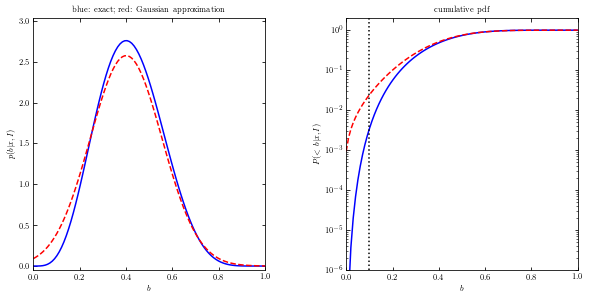

In [20]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import norm, binom
from matplotlib import pyplot as plt

#------------------------------------------------------------
# Plot posterior as a function of b
n = 10  # number of points
k = 4  # number of successes from n draws

b = np.linspace(0, 1, 100)
db = b[1] - b[0]

# compute the probability p(b) (eqn. 5.70)
p_b = b ** k * (1 - b) ** (n - k)
p_b /= p_b.sum()
p_b /= db
cuml_p_b = p_b.cumsum()
cuml_p_b /= cuml_p_b[-1]

# compute the gaussian approximation (eqn. 5.71)
b0 = k * 1. / n
sigb = np.sqrt(b0*(1-b0)/n)
p_g = norm(b0, sigb).pdf(b)
cuml_p_g = p_g.cumsum()
cuml_p_g /= cuml_p_g[-1]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(9, 5))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.35, bottom=0.18)

ax = fig.add_subplot(121)
ax.plot(b, p_b, '-b')
ax.plot(b, p_g, '--r')

ax.set_ylim(-0.05, np.max(p_b)*1.1)

ax.set_xlabel('$b$')
ax.set_ylabel('$p(b|x,I)$')
plt.title('blue: exact; red: Gaussian approximation')


ax = fig.add_subplot(122, yscale='log')
ax.plot(b, cuml_p_b, '-b')
ax.plot(b, cuml_p_g, '--r')
ax.plot([0.1, 0.1], [1E-6, 2], ':k')
plt.title('cumulative pdf')


ax.set_xlabel('$b$')
ax.set_ylabel('$P(<b|x,I)$')
ax.set_ylim(1E-6, 2)

plt.show()

### f) conceptual difficulties with the MLE 

#### An example of a difficulty with the MLE : "waiting for a bus" problem
 
Imagine you arrive at a bus stop, and observe that the bus arrives $t$ minutes later 
(it is assumed that you had no knowledge about the bus schedule). What is the mean time 
between two successive buses, $\tau$, if the buses keep a regular schedule? 

It is easy to derive an intuitive answer. The wait time is distributed uniformly in the interval $0 \le t \le \tau$, and on average you would wait for $t=\tau/2$ minutes.  Rearranging this gives $\tau = 2t$, which agrees with intuition.

What does the maximum likelihood approach give? 

The probability that you will wait $t$ 
minutes (the likelihood of data) is given by the uniform distribution (every $t$ is equally likely)
$$ p(t\,|\,\tau) =  1/\tau, $$
if $0 \le t \le \tau$ and $p(t|\tau)=0$ otherwise.


Because we only observe a single point, the data likelihood is simply equal to this probability. 
The maximum likelihood, then, corresponds to the smallest possible $\tau$ such that $t \le \tau$: 
this is satisfied by $\tau = t$ and not $\tau=2t$ as we expected!!

Computing the expectation value or the median for $\tau$ does not help either because
the resulting integrals diverge. These puzzling results are resolved by the use of appropriate prior
information, as will be discussed in a moment. We shall see several other examples later where the
addition of extra information changes the results we would get from the maximum likelihood
approach.

The Bayesian method is not, however, motivated by the differences in results
between maximum likelihood and Bayesian techniques.  These differences are
often negligible, especially when the data sets are large.  Rather, **the Bayesian
method is motivated by its ability to provide a full probabilistic framework
for data analysis**. One of the most important aspects of Bayesian analysis is the 
ability to straightforwardly incorporate unknown or uninteresting model 
parameters, the so-called nuisance parameters, in data analysis. 

### For completeness: Bayesian solution to "bus arrival problem" (we will go through details in Lecture 12)
 

In our **bus arrival problem**, $\tau$ is unknown model parameter and data (datum) is $t$. The
posterior pdf for $\tau$ is (we ignore normalization): 
$$p(\tau\,|\,t, I) \propto p(t\,|\,\tau,I) \, p(\tau\,|\,I).$$

The likelihood of data is given by the uniform distribution (every $t$ is equally likely, with 
$0 \le t \le \tau$):
$$ p(t\,|\,\tau,I) =  1/\tau. $$  

Following the Principle of Invariance, we assign the prior
$$ p(\tau\,|\,I) = 1/ \tau.$$

Note: the two pdfs look the same but this is essentially a coincidence. 

So, we have 
    $$p(\tau \,|\, t,I) \propto  \frac{1}{\tau^2},$$
for $\tau > t$ and 0 otherwise. We use normalization constraint 
$$ \int_t^\infty p(\tau\,|\,I)d\tau = \int_t^\infty \frac{C}{\tau^2} d\tau \equiv 1,$$
to get $C=t$ (the divergent integral over $\tau$ encountered in the maximum likelihood 
analysis is mitigated here by the extra $\tau$ term from the prior).

The properly normalized posterior pdf for $\tau$ (valid for $\tau > t$) is thus 
$$   p(\tau \,|\, t,I) = \frac{t}{\tau^2}.$$
  
  
The median $\tau$ given by the posterior $p(\tau \,|\, t,I)$ is now equal to $2t$, 
in agreement with our expectations. 

An interesting side result is that the p% quantiles 
are equal to ($1-t/\tau$); for example, the 95% confidence region for $\tau$, 
or **the credible region**, spans $1.03 t < \tau < 40 t$. If we waited for a bus 
for just 1 minute, then, adopting the usual 95% confidence region, we cannot reject the 
possibility that $\tau$ is as large as 40 minutes. 

Equivalently, if we waited for a 
bus for 1 minute, we can paraphrase Laplace and say that “it is a bet of 20 against 1 
that **the bus will arrive in the interval between 0.03 minutes and 39 minutes from now**.”





### g) what if we cannot write down the likelihood function? 

Sometimes you need to think harder. If no success, one can use methods
such as **Approximate Bayesian Computation** (ABC).  ABC is essentially a
rejection algorithm that only "accepts" model parameter values (drawn
from prior) for which some judiciously chosen "summary statistic" is 
"close enough" to its value computed from data. 

We don't have time to discuss ABC in depth, but you can look it up on Wikipedia! 

https://en.wikipedia.org/wiki/Approximate_Bayesian_computation

In addition, here is a 
[practical ABC example from astroML](https://www.astroml.org/book_figures/chapter5/fig_ABCexample.html)


 

### What did we learn today? 

1. Likelihood function plays a central role in both frequentist and Bayesian
data analysis - it encapsulates our knowledge (beliefs) about the data generation process

2. In frequentist framework, likelihood is only one of possible cost functions; in Bayesian
   framework, it plays a major role. 

3. Maximum likelihood method provides theoretical foundations for many common results
(e.g. weighted mean) and enables fitting of complex functions to data.

4. For normal (gaussian) distribution, MLE method becomes $\chi^2$ minimization. 

5. **Likelihood doesn't have to be gaussian** - indeed, sometimes it's impossible to 
write it down!

6. ML method, while exceedingly useful, can sometimes produce counter-intuitive results - Bayes to the rescue! 


